In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import math

from keras.models import Sequential
from keras.regularizers import L1L2
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten

#import pydot
from keras.utils.vis_utils import plot_model
#from keras.layers import Bidirectional
#from keras.layers import Dropout
tf.random.set_seed(42)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('seaborn-colorblind')
sns.set_theme()
%matplotlib inline

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
          'figure.titlesize': 'x-large',
          'figure.dpi': 150,
         'axes.labelsize': 'x-large',
         'axes.titlesize': 'x-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'savefig.bbox': 'tight'}

plt.rcParams.update(params)
# plt.rcParams.keys() ### Use to check the available parameters
#tf.debugging.set_log_device_placement(True) ### Use to debug use of GPU

# Select region

In [ ]:
region ='DK2'

# Data load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%run 'drive/My Drive/MONTA/ts_modelling.py'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv("drive/My Drive/MONTA/Spot_Price_Nordics.csv")
df = df[[f'{region}', "datetime"]]
df["datetime"] = pd.to_datetime(df["datetime"])
df.set_index("datetime", inplace = True)


In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
train_size = 1968
test_size = 96
df = df.iloc[len(df)-(test_size+train_size):]
df.reset_index() # No inplace, jsut to see index ranges

,datetime,DK2
0,2021-12-17 00:00:00,19.95
1,2021-12-17 01:00:00,19.36
2,2021-12-17 02:00:00,19.06
3,2021-12-17 03:00:00,19.15
4,2021-12-17 04:00:00,18.79
...,...,...
2059,2022-03-12 19:00:00,210.25
2060,2022-03-12 20:00:00,198.64
2061,2022-03-12 21:00:00,170.43
2062,2022-03-12 22:00:00,153.95


In [ ]:
data = df[:train_size]
test = df[train_size:]
p_min = data.min()
p_max = data.max()
ndata = (data-p_min)/(p_max-p_min)
ntest = (test-p_min)/(p_max-p_min)

# Modelling

## Forecasting


Input (Kernel) regularization documentation: https://keras.io/api/layers/regularizers/

MAE (L1 Loss):  https://angela-wong.medium.com/rmse-or-mae-which-and-why-loss-functions-used-in-regression-and-classification-a98afc9fa215

In [ ]:
n_steps_in = 168
n_steps_out = 96
# General data normalization

indexes=[]
preds = []

in_seq = ndata[:train_size].values
x_input = ndata[train_size-n_steps_in:].values  # Last sequence of in_seq, to use for prediction
y_true = ntest # Values to be predicted
# convert to [rows, columns] structure
in_seq = in_seq.reshape((len(in_seq), 1))
#in_seq2 = in_seq2.reshape((len(in_seq2), 1))
#out_seq = out_seq.reshape((len(out_seq), 1))
dataset=np.hstack((in_seq, in_seq))
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
n_features= X.shape[2]   
model = Sequential()
model.add(LSTM(168, input_shape=(n_steps_in, n_features), return_sequences=True, kernel_regularizer=L1L2(l1=0.001, l2=0.001)))
model.add(Flatten())
model.add(Dense(n_steps_out)) # Since it is not a batch-like processing,
                              # the output needs to be of the correct time-steps.
model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse']) # L1 Loss - better because it penalizes outliers.

print(X.shape,"\n")
print(y.shape)
history=model.fit(X, y, epochs=100, verbose=1, validation_split=0.1)

# with open(f'modelsummary_Fold_{ii}.txt', 'w') as f:
#    model.summary(print_fn=lambda x: f.write(x + '\n'))


x_input = x_input.reshape((1, n_steps_in, n_features))
preds.append([model.predict(x_input, verbose=0)]) # Save predictions for evaluation: rmse, mape...
#with open(f"preds_fold_{ii}.txt", "w") as output:
#    output.write(str(preds))   # Save predictions in case memory breaks

(1706, 168, 1) 

(1706, 96)
Epoch 1/100
48/48 [==============================] - 3s 25ms/step - loss: 0.1059 - mae: 0.0849 - mse: 0.0116 - val_loss: 0.2139 - val_mae: 0.2023 - val_mse: 0.0551
Epoch 2/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0789 - mae: 0.0716 - mse: 0.0083 - val_loss: 0.2451 - val_mae: 0.2404 - val_mse: 0.0740
Epoch 3/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0746 - mae: 0.0704 - mse: 0.0081 - val_loss: 0.2373 - val_mae: 0.2336 - val_mse: 0.0704
Epoch 4/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0724 - mae: 0.0690 - mse: 0.0078 - val_loss: 0.2425 - val_mae: 0.2394 - val_mse: 0.0740
Epoch 5/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0718 - mae: 0.0690 - mse: 0.0079 - val_loss: 0.2506 - val_mae: 0.2481 - val_mse: 0.0801
Epoch 6/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0711 - mae: 0.0687 - mse: 0.0078 - val_loss: 0.2393 - val_mae: 0.2372 - val_

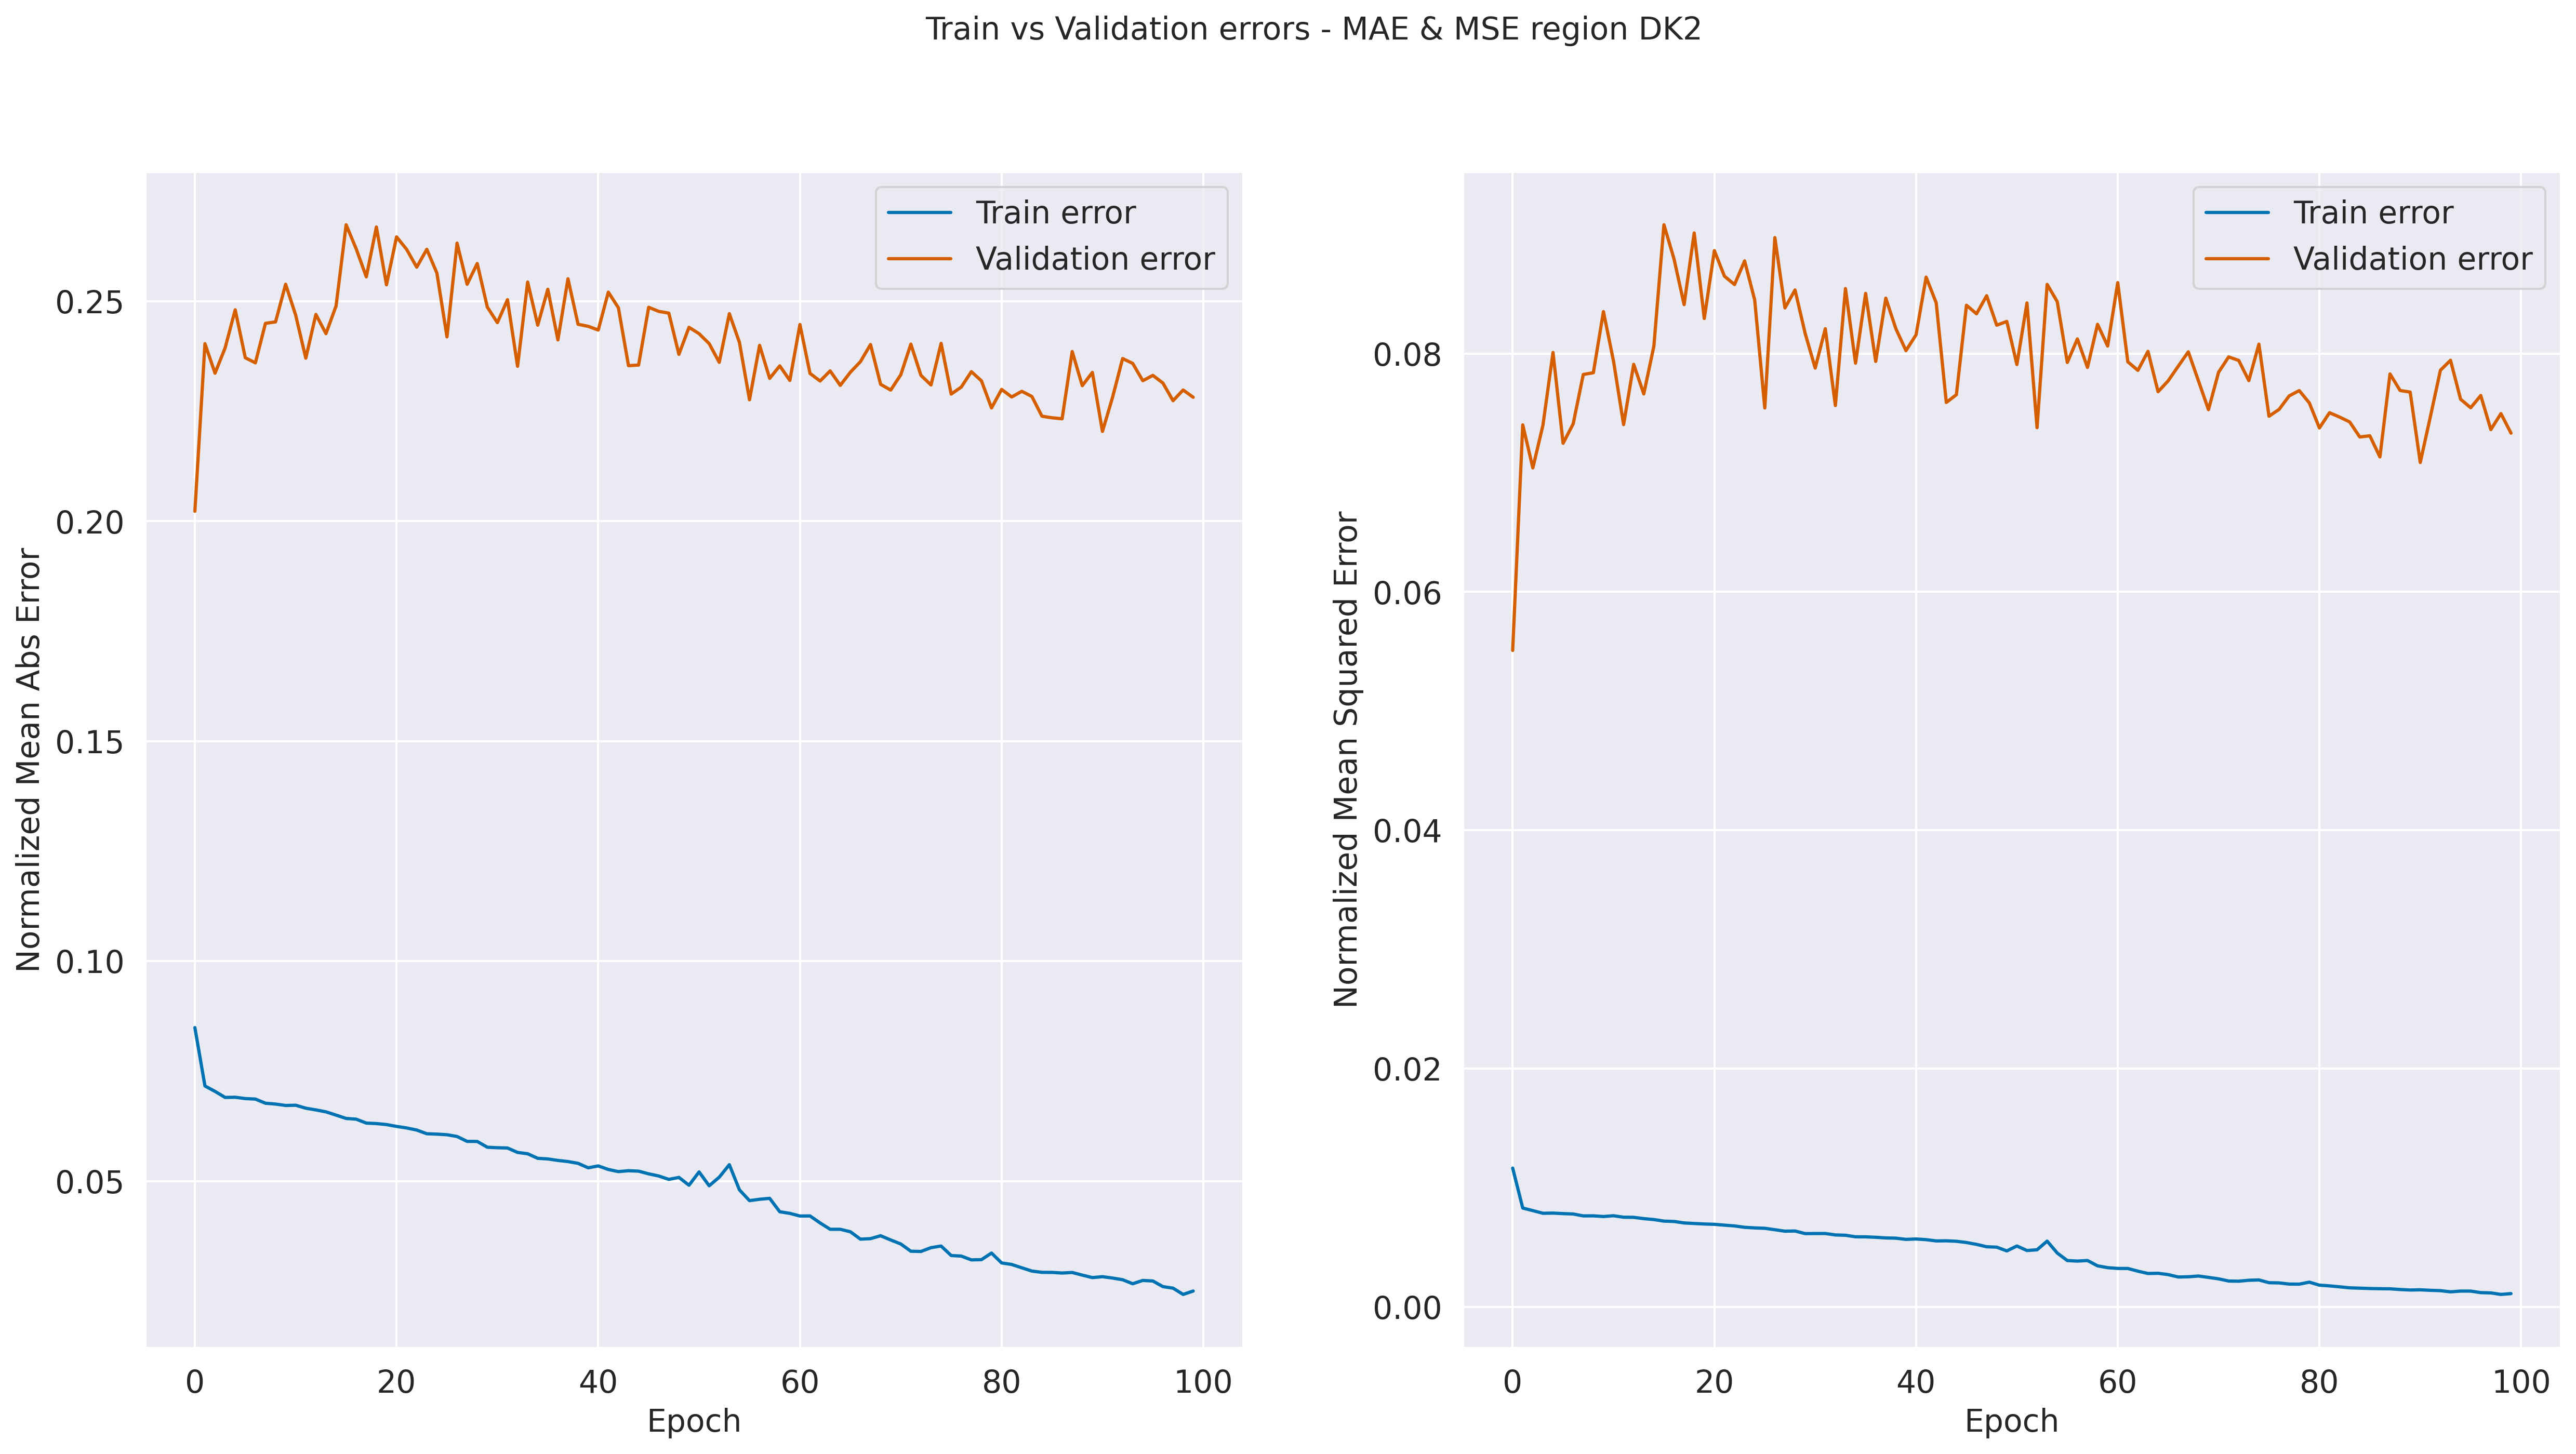

In [ ]:
def plot_history(history: tf.keras.callbacks.History, region) -> None:
  """
  Plot training vs Validation MAE and MSE over epoch
  """
  hist=pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  fig, axes = plt.subplots(nrows=1, ncols=2)
  fig.suptitle(f'Train vs Validation errors - MAE & MSE region {region}')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Normalized Mean Abs Error');
  axes[0].plot(hist['epoch'], hist['mae'], label='Train error')
  axes[0].plot(hist['epoch'], hist['val_mae'], 'C2', label='Validation error')
  axes[0].legend()
  
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Normalized Mean Squared Error');
  axes[1].plot(hist['epoch'], hist['mse'], label='Train error')
  axes[1].plot(hist['epoch'], hist['val_mse'], 'C2', label='Validation error')
  axes[1].legend()

  
  plt.legend()
  plt.savefig(f'drive/My Drive/MONTA/Plots/LSTM_regions/Train_Val_errors_region_{region}.jpg')
  plt.show()
  print("\n")

plot_history(history, region)

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 168, 168)          114240    
                                                                 
 flatten_10 (Flatten)        (None, 28224)             0         
                                                                 
 dense_10 (Dense)            (None, 96)                2709600   
                                                                 
Total params: 2,823,840
Trainable params: 2,823,840
Non-trainable params: 0
_________________________________________________________________


In [ ]:
preds

[[array([[0.61930627, 0.59419376, 0.47873214, 0.4449078 , 0.39079872,
          0.3664414 , 0.3233783 , 0.24508525, 0.23333247, 0.23664495,
          0.22475816, 0.20355767, 0.16725987, 0.14650868, 0.10887644,
          0.07786597, 0.0685029 , 0.09783005, 0.16899714, 0.17915785,
          0.16523361, 0.19532463, 0.18036167, 0.18266183, 0.2086785 ,
          0.19981033, 0.24619322, 0.21278559, 0.21963364, 0.18460584,
          0.17287472, 0.13888584, 0.1258243 , 0.13417053, 0.1730008 ,
          0.15467119, 0.18634275, 0.15710841, 0.13445425, 0.1358574 ,
          0.11658943, 0.07183056, 0.08949809, 0.12196723, 0.15456484,
          0.10822114, 0.14983326, 0.17658585, 0.16367374, 0.1487335 ,
          0.10775679, 0.1227342 , 0.12393571, 0.10118432, 0.09382612,
          0.16338646, 0.1529136 , 0.18396896, 0.1987173 , 0.20030475,
          0.15875413, 0.19724062, 0.1708886 , 0.15215936, 0.1375654 ,
          0.09567188, 0.12091802, 0.14686885, 0.16320229, 0.17961887,
          0.19751483

## Evaluation

### De-Normalization

In [ ]:
# Remove list(array(list(list(value))) structure...
predsd = [(val * (p_max - p_min) + p_min) for matrix in preds
          for sublist in matrix
          for subsublist in sublist
          for val in subsublist]
         #for val in arr]
# Correct number of folds -> Match folds performed prediction
#predsd = [[predsd[j] for j in range(96)] for i in range(folds)]


# arr_prices=np.array(predsd).reshape([20, 96])
# print(arr_prices[0].shape)
print(predsd)

[DK2    433.525807
dtype: float64, DK2    415.947804
dtype: float64, DK2    335.128135
dtype: float64, DK2    311.452123
dtype: float64, DK2    273.577378
dtype: float64, DK2    256.527986
dtype: float64, DK2    226.385105
dtype: float64, DK2    171.582325
dtype: float64, DK2    163.355729
dtype: float64, DK2    165.674368
dtype: float64, DK2    157.353971
dtype: float64, DK2    142.514262
dtype: float64, DK2    117.106893
dtype: float64, DK2    102.58168
dtype: float64, DK2    76.24024
dtype: float64, DK2    54.533845
dtype: float64, DK2    47.979977
dtype: float64, DK2    68.5081
dtype: float64, DK2    118.322927
dtype: float64, DK2    125.435122
dtype: float64, DK2    115.688571
dtype: float64, DK2    136.751381
dtype: float64, DK2    126.27776
dtype: float64, DK2    127.887802
dtype: float64, DK2    146.098689
dtype: float64, DK2    139.891234
dtype: float64, DK2    172.357865
dtype: float64, DK2    148.973527
dtype: float64, DK2    153.766958
dtype: float64, DK2    129.248548
dtyp

### Plotting

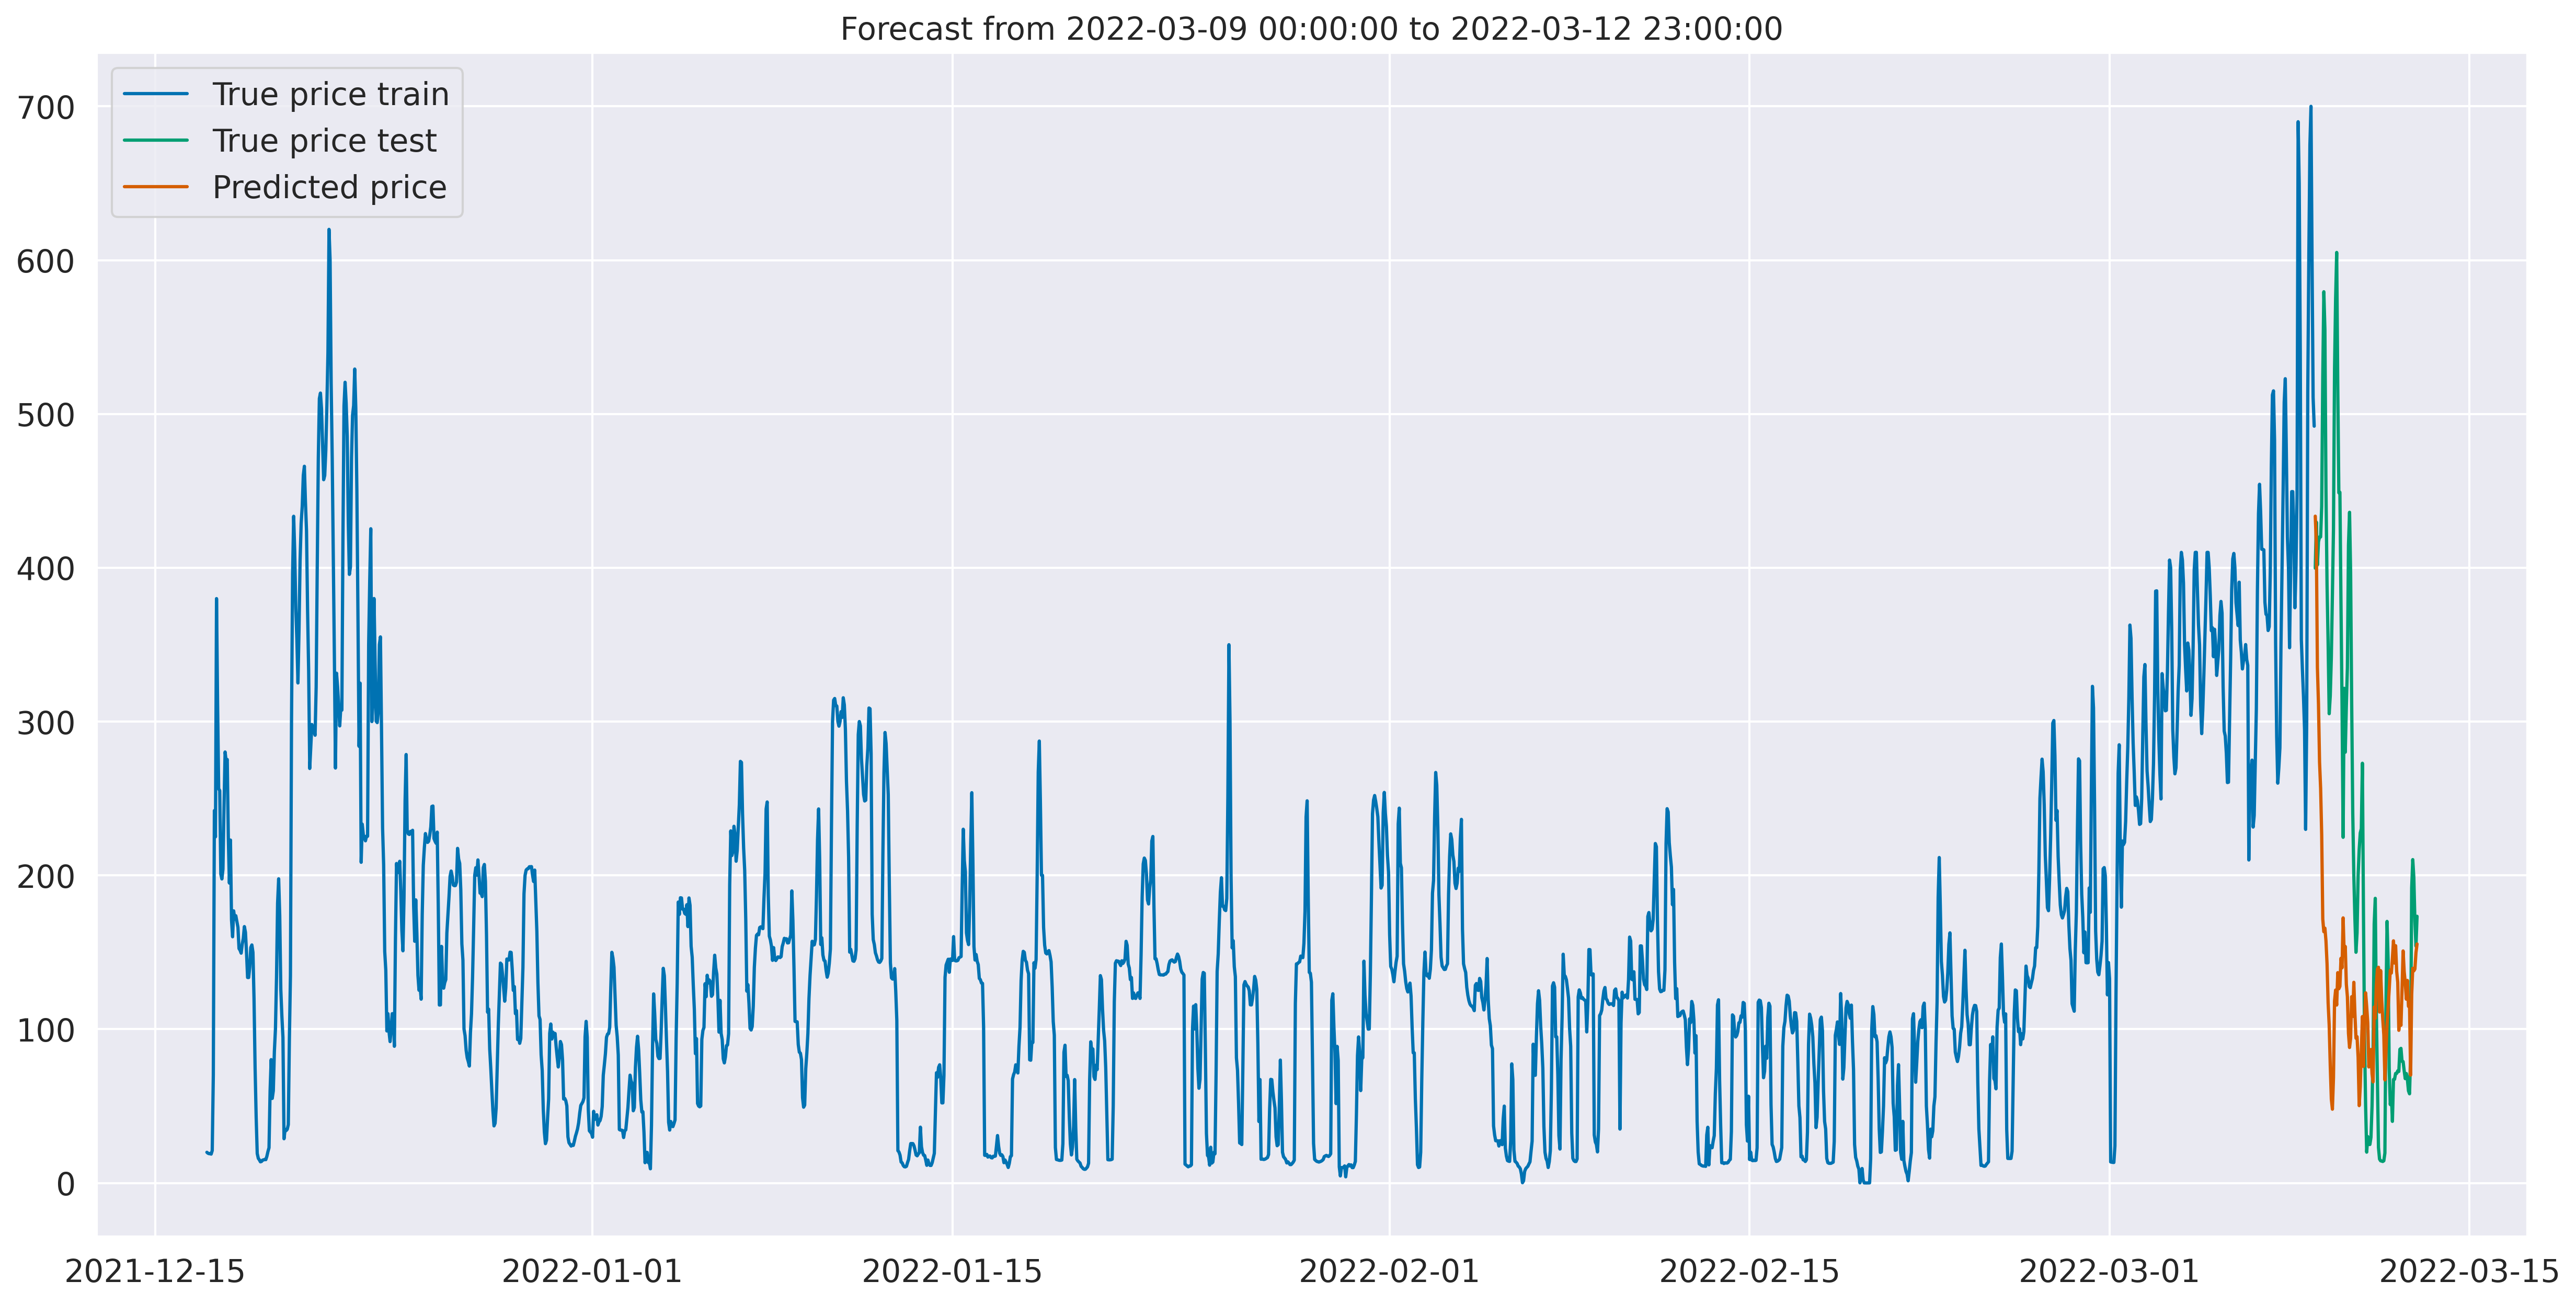

In [ ]:
plt.rcParams.update(params)

fig = plt.figure(figsize=(20,10))
plt.plot(data[:train_size], label = "True price train")
plt.plot(test, label = "True price test")
#len(data[indexes[0][0]:indexes[0][1]].index)
plt.plot(test.index, predsd, label = "Predicted price")
plt.title(f'LSTM Forecast of region {region}')
plt.legend()
fig.savefig(f'drive/My Drive/MONTA/Plots/LSTM_regions/Pred LSTM region {region}.jpg')
plt.show()   

### RMSE

In [ ]:
rmse = (np.sqrt(mean_squared_error(test, predsd)))
mape = calculate_mape(test, predsd)
print(f' Average MAPE: {mape}')
print(f' Average RMSE: {rmse}')

 Average MAPE: 112.71
 Average RMSE: 179.18135665356812


In [ ]:
regions=['NO1', 'NO3', 'NO5', 'SE1', 'SE3', 'SE4', 'DK1', 'DK2']
for reg in regions:
  df=pd.read_csv(f"drive/My Drive/MONTA/Plots/LSTM_regions/{reg}/Preds_{reg}.csv")
  print(reg, np.sqrt(mean_squared_error(df[reg], df['Predicted Price'])), calculate_mape(df[reg], df['Predicted Price']))

NO1 29.523002582916632 11.9
NO3 1.5535083101400013 8.41
NO5 33.86466538225729 13.39
SE1 6.010776266819586 29.51
SE3 109.84529436516834 105.45
SE4 102.21076842847897 115.45
DK1 163.90346852522316 3528.07
DK2 179.18135665356812 112.71


### Time-related

In [ ]:
preds_values = [(val * (p_max - p_min) + p_min) for matrix in preds
          for sublist in matrix
          for subsublist in sublist
          for val in subsublist]

preds_idx = pd.to_datetime(test.index)
#preds_idx

In [ ]:
preds_idx

DatetimeIndex(['2022-03-09 00:00:00', '2022-03-09 01:00:00',
               '2022-03-09 02:00:00', '2022-03-09 03:00:00',
               '2022-03-09 04:00:00', '2022-03-09 05:00:00',
               '2022-03-09 06:00:00', '2022-03-09 07:00:00',
               '2022-03-09 08:00:00', '2022-03-09 09:00:00',
               '2022-03-09 10:00:00', '2022-03-09 11:00:00',
               '2022-03-09 12:00:00', '2022-03-09 13:00:00',
               '2022-03-09 14:00:00', '2022-03-09 15:00:00',
               '2022-03-09 16:00:00', '2022-03-09 17:00:00',
               '2022-03-09 18:00:00', '2022-03-09 19:00:00',
               '2022-03-09 20:00:00', '2022-03-09 21:00:00',
               '2022-03-09 22:00:00', '2022-03-09 23:00:00',
               '2022-03-10 00:00:00', '2022-03-10 01:00:00',
               '2022-03-10 02:00:00', '2022-03-10 03:00:00',
               '2022-03-10 04:00:00', '2022-03-10 05:00:00',
               '2022-03-10 06:00:00', '2022-03-10 07:00:00',
               '2022-03-

In [ ]:
preds_df = pd.DataFrame(data=preds_values, index = preds_idx)
preds_df.reset_index(inplace = True)
preds_df.columns = ["datetime", "Predicted Price"]
preds_df["hour"] = preds_df["datetime"].dt.hour
preds_df["dayofweek"] = preds_df["datetime"].dt.weekday
#true_test = data.reset_index()
preds_df = preds_df.merge(test, how = "left", on = "datetime")
# Square root of the incremental mean of the difference
preds_df["RMSE"] = np.sqrt(((preds_df["Predicted Price"] - preds_df[f'{region}'])**2).expanding().mean()) 

In [ ]:
drive_path='drive/My Drive/MONTA/'
folder = "Plots/"
subfolder = "LSTM_regions/"
filename = f"/Preds_{region}"
filetype = ".csv"
preds_df.to_csv(path_or_buf=drive_path+folder+subfolder+filename+filetype)
preds_df.head() # Data check

,datetime,Predicted Price,hour,dayofweek,DK2,RMSE
0,2022-03-09 00:00:00,433.525807,0,2,399.73,33.795807
1,2022-03-09 01:00:00,415.947804,1,2,429.70,25.799995
2,2022-03-09 02:00:00,335.128135,2,2,401.80,43.880204
3,2022-03-09 03:00:00,311.452123,3,2,416.88,64.983564
4,2022-03-09 04:00:00,273.577378,4,2,420.03,87.566917


hour
0     193.905609
1     190.120216
2     192.461463
3     196.101719
4     199.943551
5     202.572067
6     206.690918
7     217.636717
8     227.896459
9     233.214272
10    233.407404
11    232.159445
12    230.499118
13    228.438465
14    227.060717
15    226.511230
16    226.866227
17    227.560923
18    229.115062
19    231.063199
20    233.439837
21    233.432104
22    232.520155
23    231.645533
Name: RMSE, dtype: float64

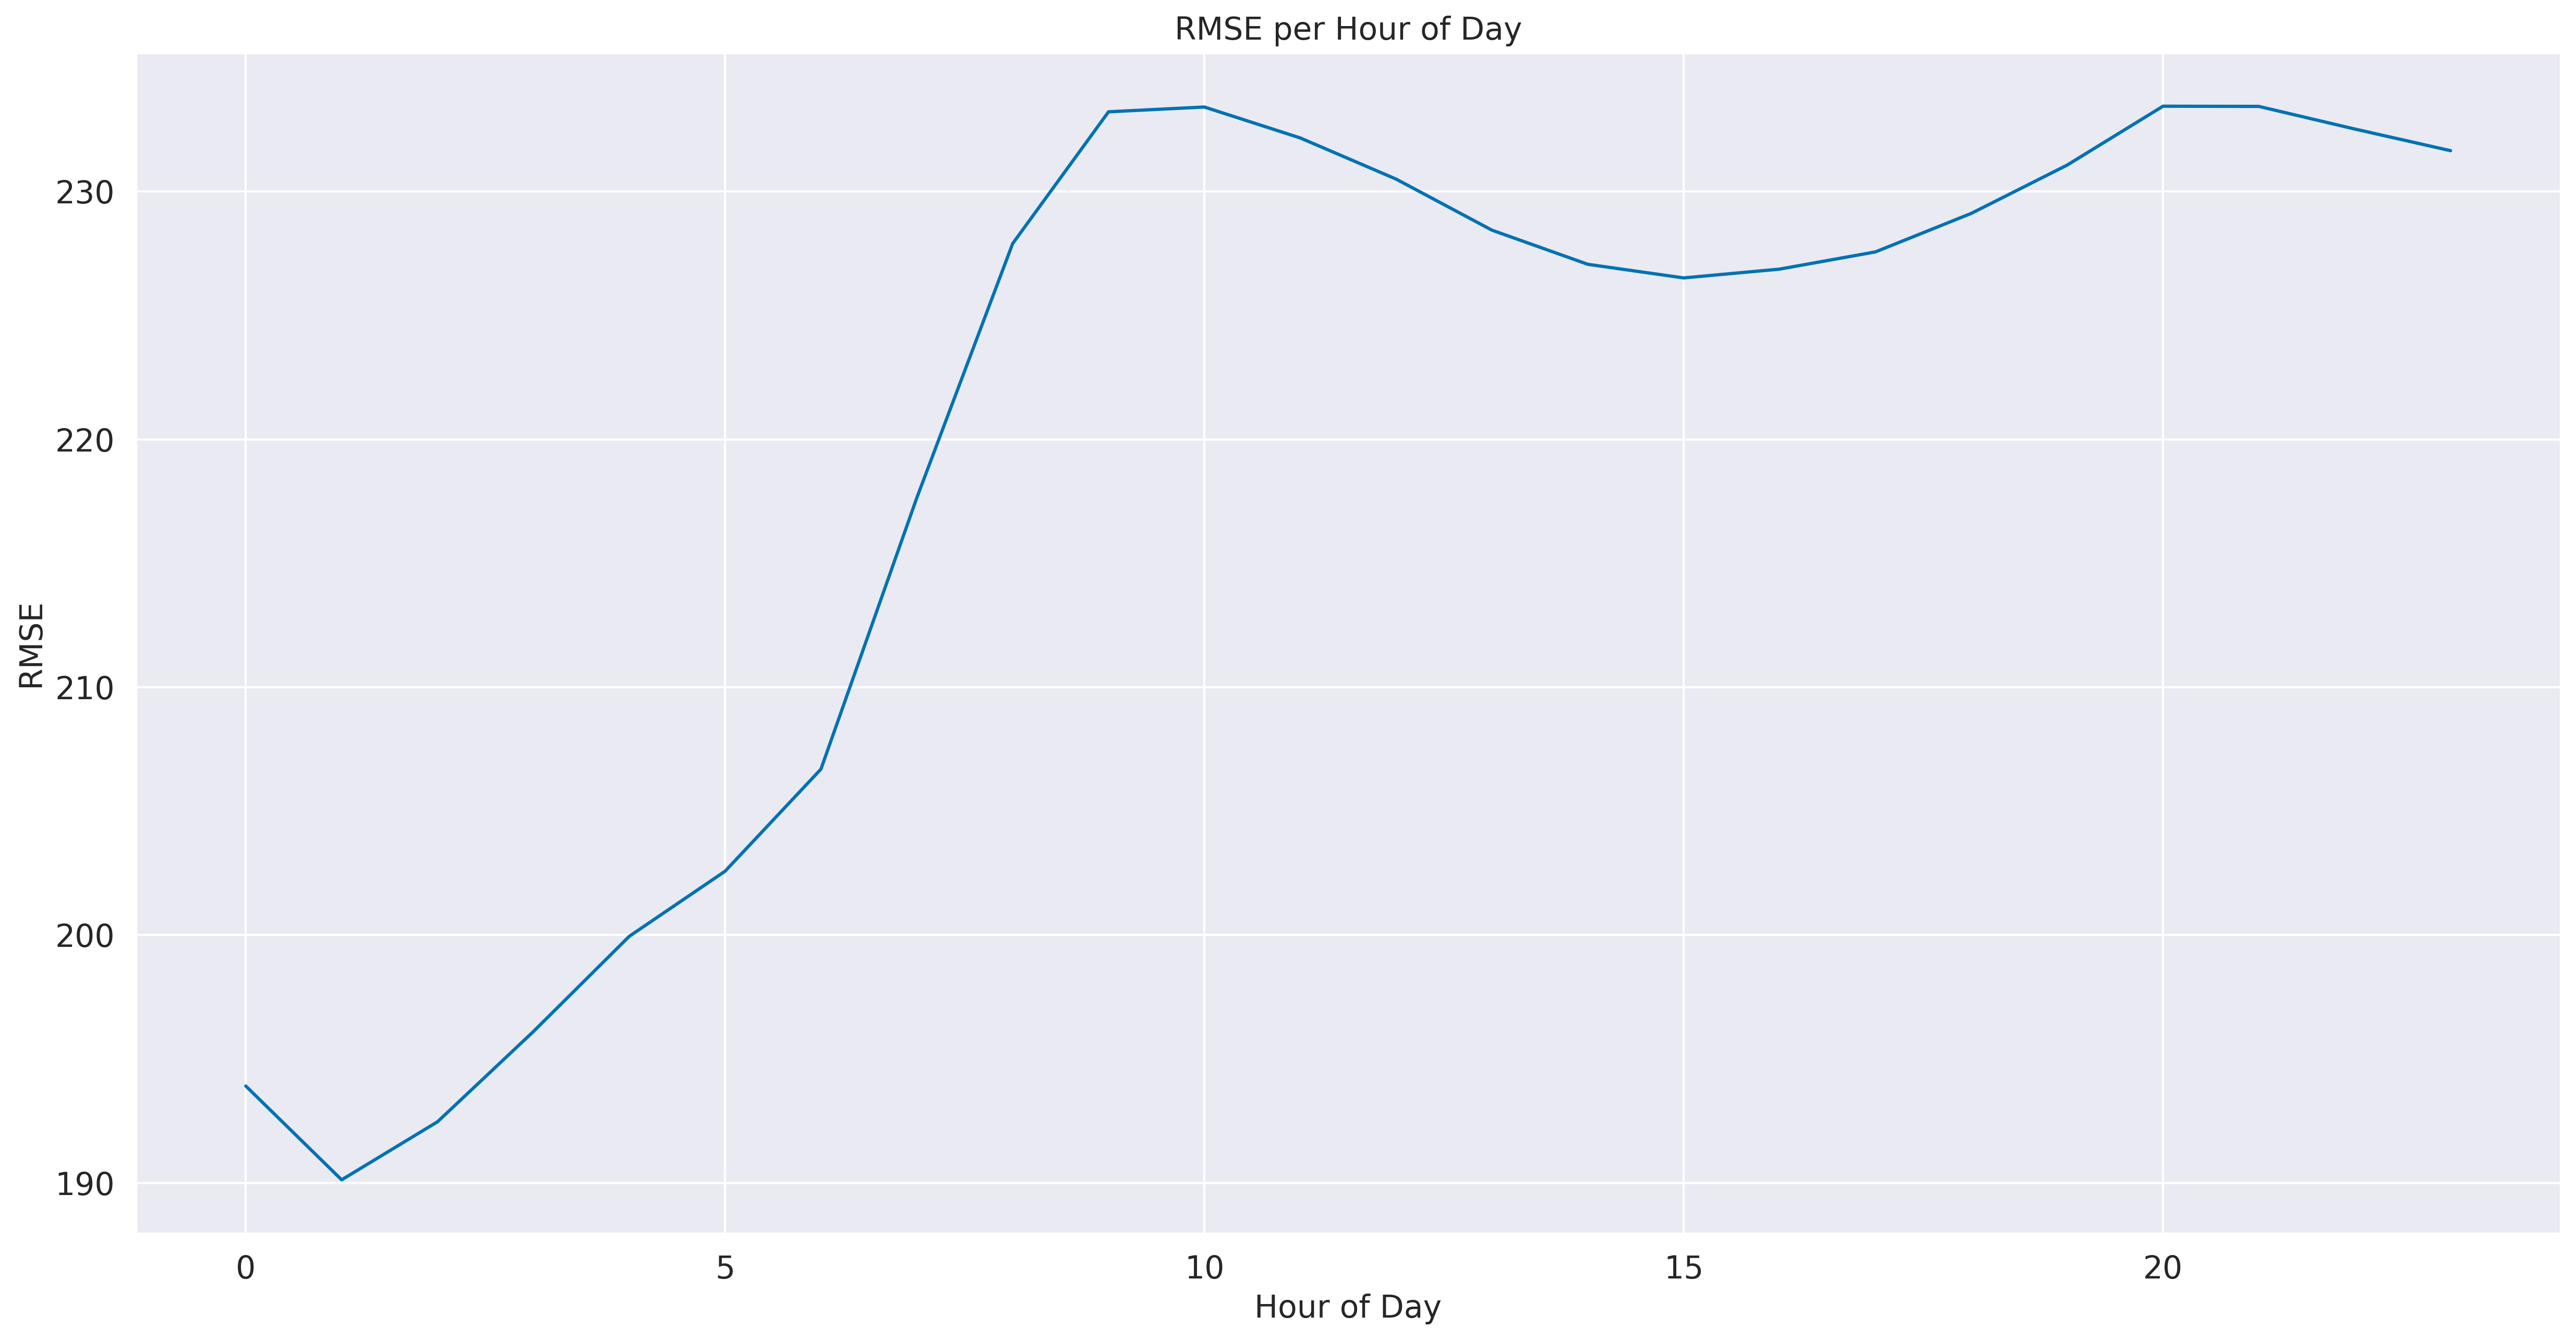

In [ ]:
hour_preds = preds_df.groupby("hour")["RMSE"].mean()
display(hour_preds)
plt.plot(hour_preds,"C0")
plt.xlabel('Hour of Day') 
plt.ylabel('RMSE') 
plt.title("RMSE per Hour of Day")
plt.savefig(f'drive/My Drive/MONTA/Plots/LSTM_regions/Region {region} Hourly error.jpg')
plt.show()

dayofweek
2    199.575160
3    269.407609
4    221.219712
5    190.507921
Name: RMSE, dtype: float64

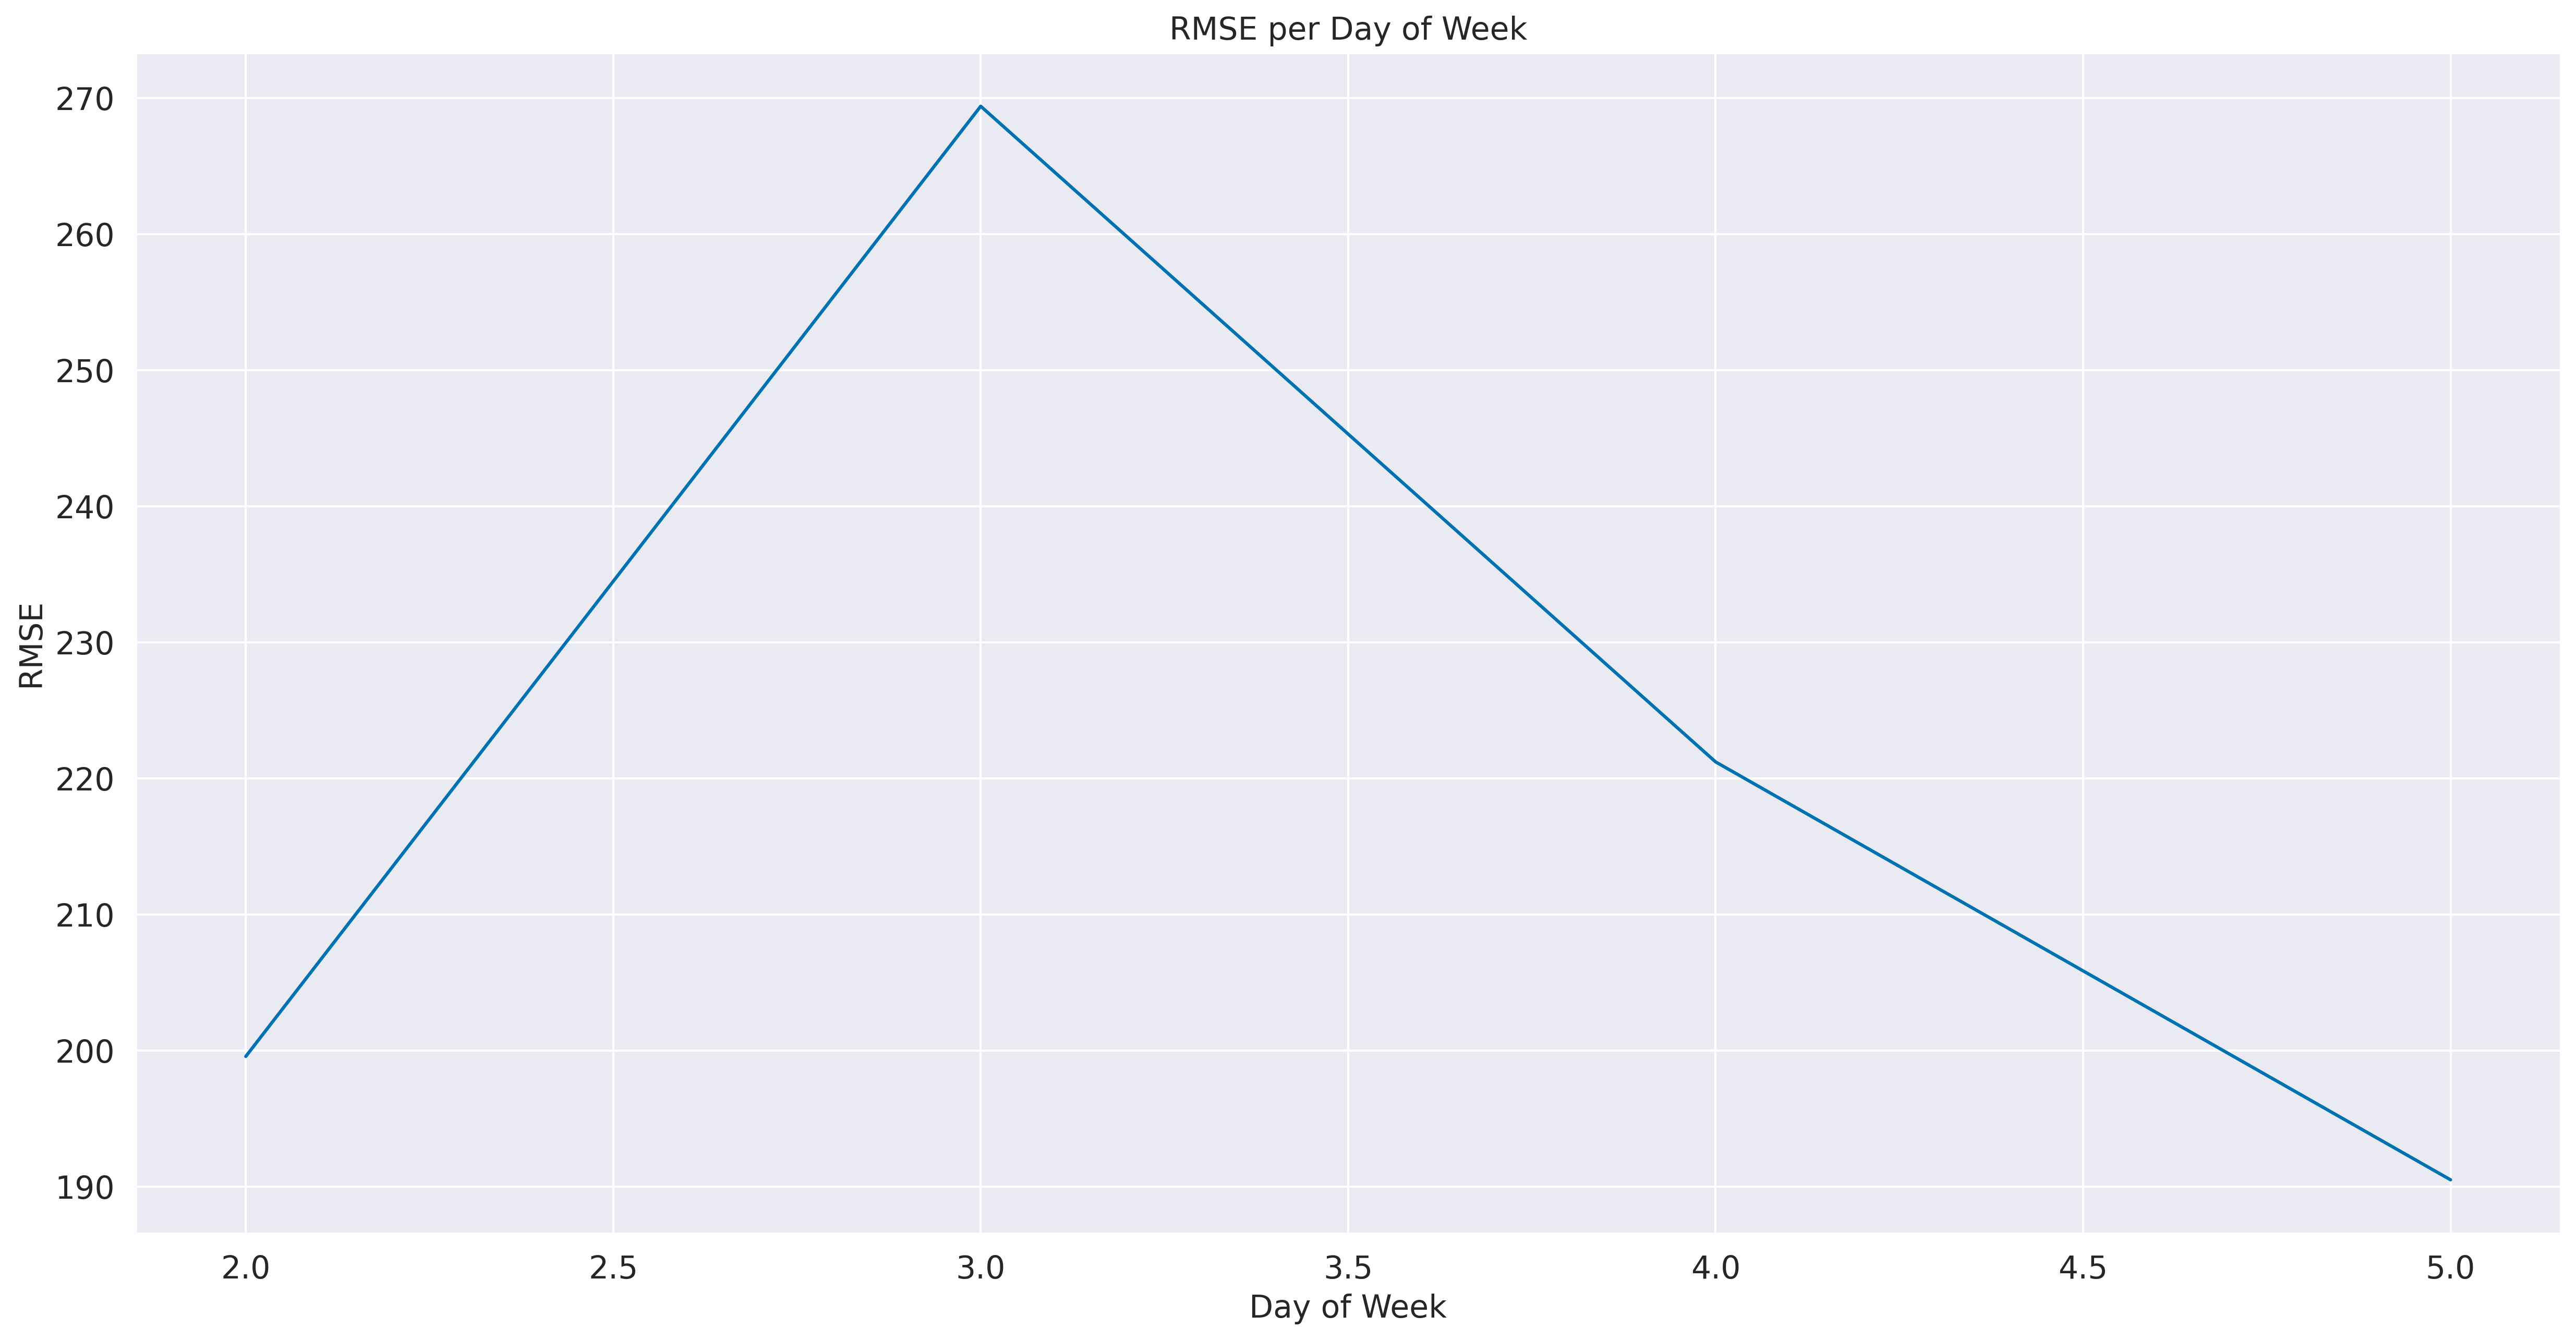

In [ ]:
preds_df["dayofweek"] = preds_df["datetime"].dt.dayofweek
weekday_preds = preds_df.groupby("dayofweek")["RMSE"].mean()
display(weekday_preds)
plt.plot(weekday_preds,"C0")
plt.xlabel('Day of Week') 
plt.ylabel('RMSE') 
plt.title("RMSE per Day of Week")
plt.savefig(f'drive/My Drive/MONTA/Plots/LSTM_regions/Region {region} Day of Week error.jpg')
plt.show()

dayofweek,2,3,4,5
hour,,,,
0,33.795807,296.444145,242.351350,203.031132
1,25.799995,292.610510,240.143543,201.926815
2,43.880204,287.317646,237.882112,200.765888
3,64.983564,284.020152,235.735008,199.668150
4,87.566917,280.064091,233.631831,198.511366
5,104.141517,277.328768,231.475731,197.342252
6,125.757168,275.512529,229.381542,196.112433
7,171.294035,276.917940,227.438915,194.895980
8,212.881713,279.336192,225.671590,193.696342


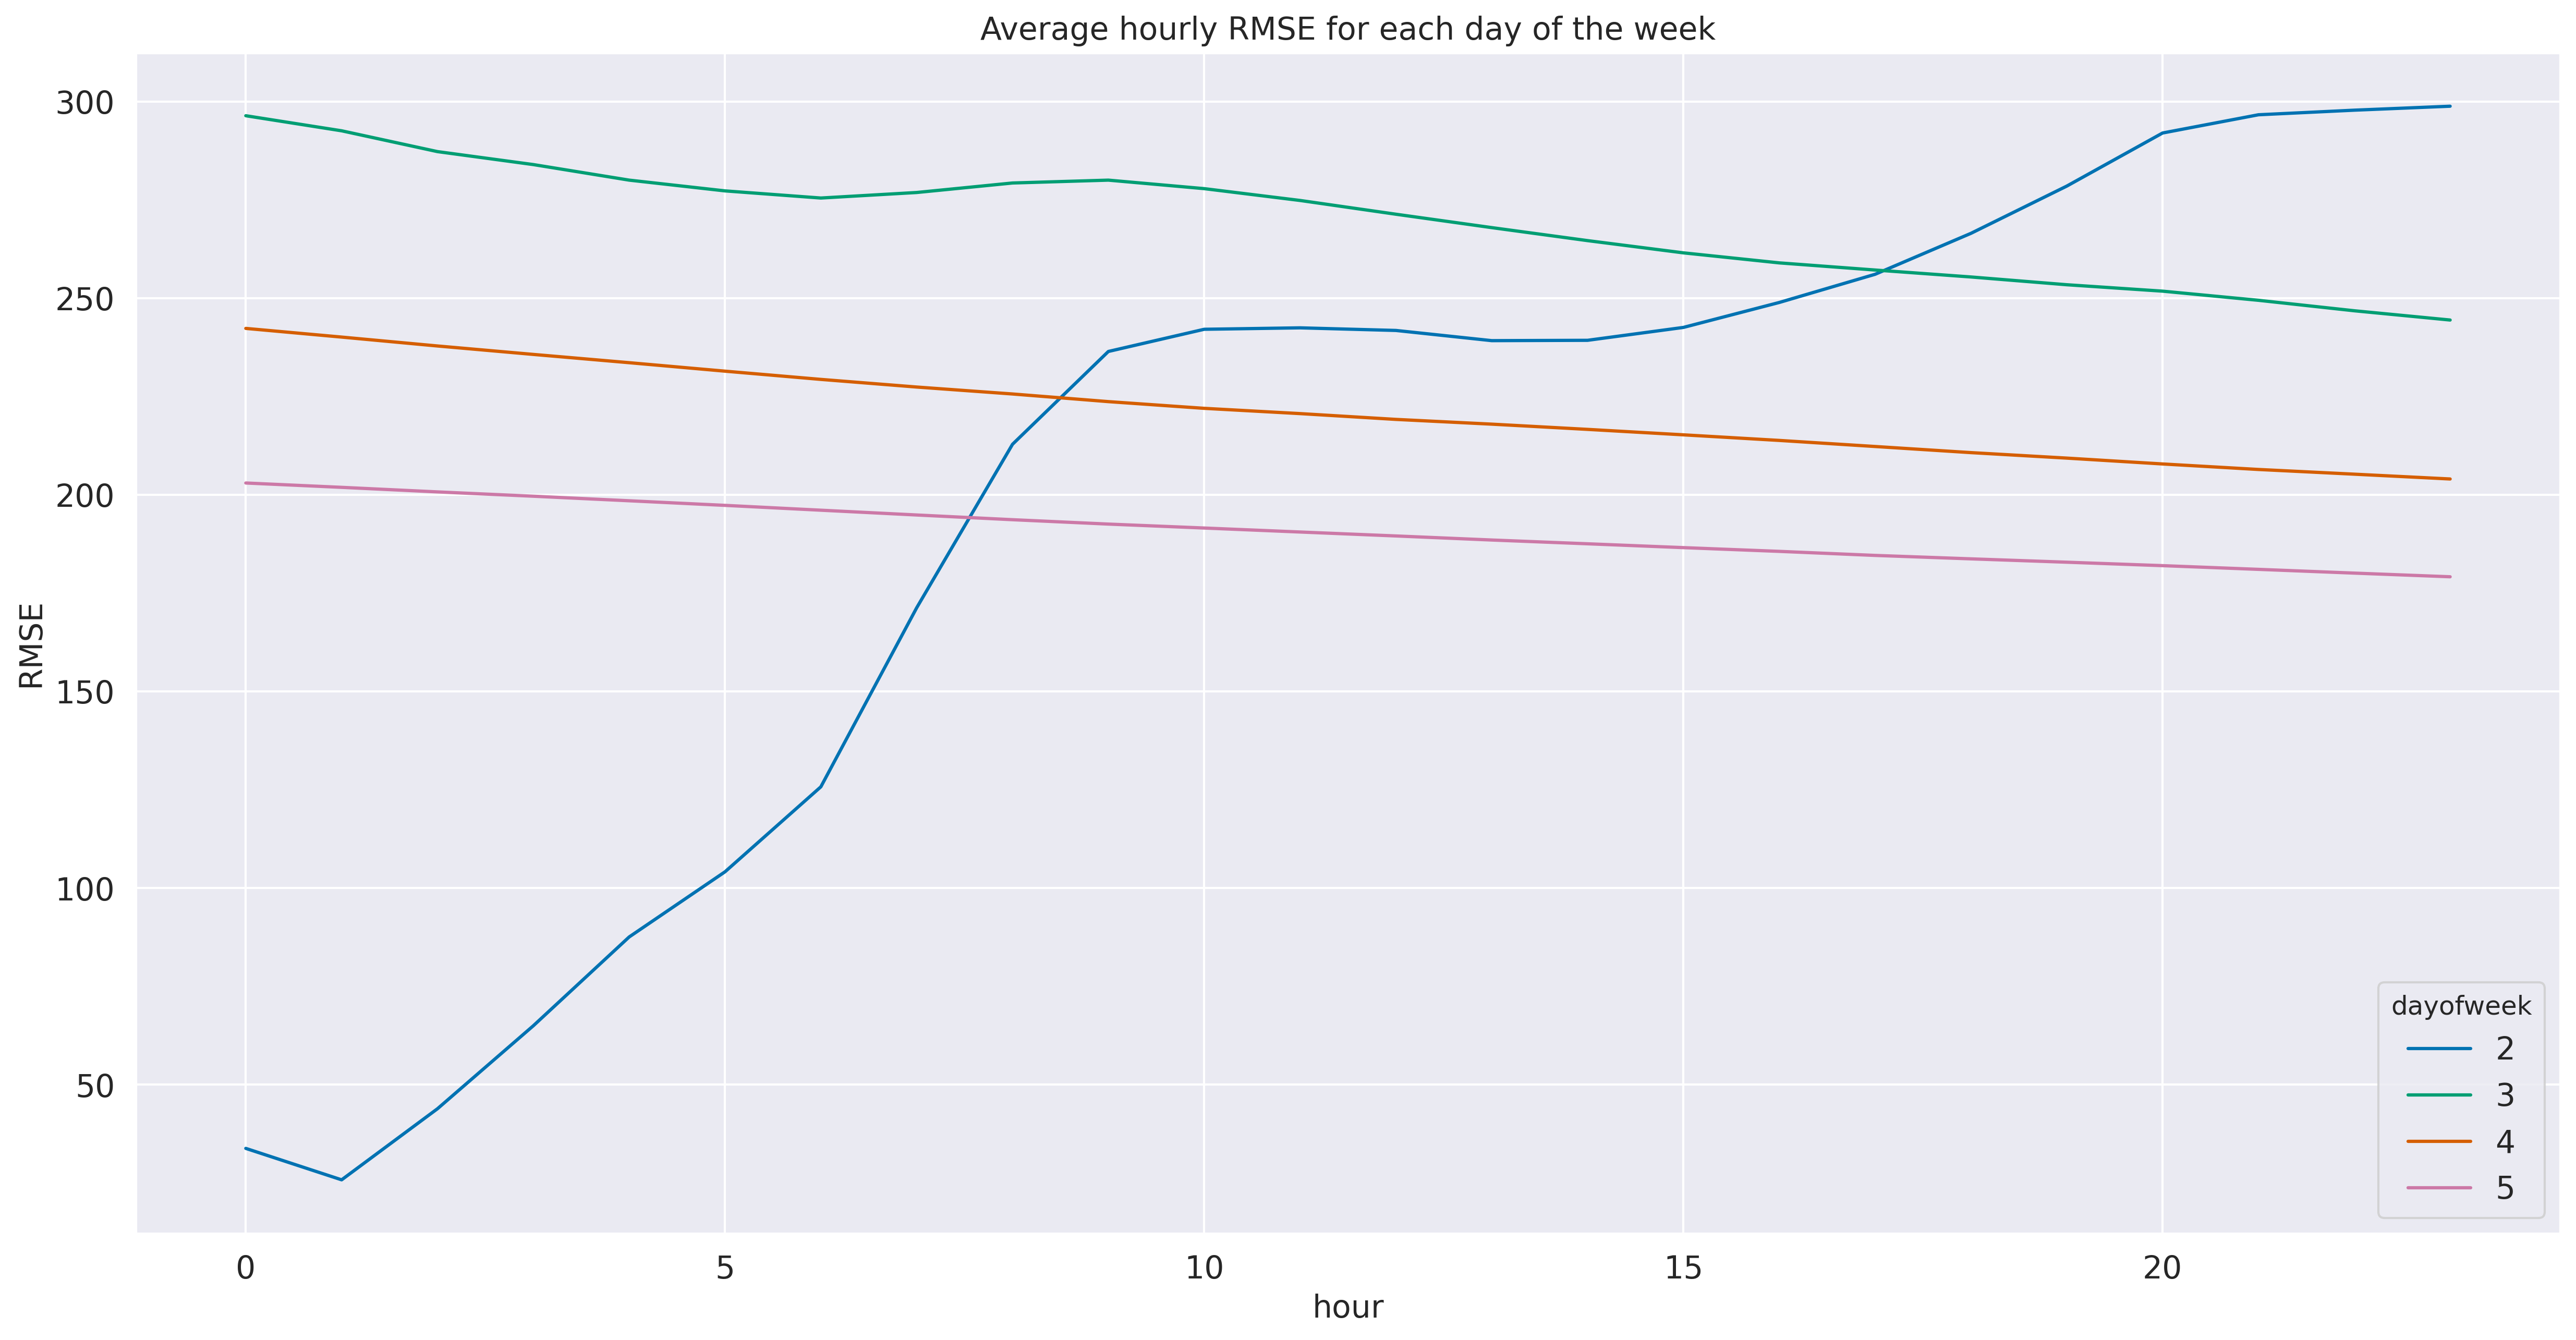

In [ ]:
hour_day = pd.pivot_table(data = preds_df, values="RMSE",
                            index = "hour", columns="dayofweek",
                            aggfunc="mean")
display(hour_day)
hour_day.plot()
plt.ylabel("RMSE")
plt.title("Average hourly RMSE for each day of the week")
plt.savefig(f'drive/My Drive/MONTA/Plots/LSTM_regions/Region {region} Average hourly RMSE for each day.jpg')
plt.show()